# Training the Language-Based Type Estimator

## Boilerplate

* For code change detection
* Seeing log messages inside the notebook
* Checking TensorFlow configuration.
* Setting random seeds

In [1]:
%load_ext autoreload
%autoreload 2

SEED: int = 42

import logging
logger: logging.Logger = logging.getLogger()
logger.setLevel(logging.INFO)

import tensorflow as tf
tf.random.set_seed(SEED)

import numpy as np
np.random.seed(SEED)

logging.info(f"Tensorflow version {tf.__version__}")
logging.info(f"Devices available: {tf.config.list_physical_devices()}")

logging.info("Starting analysis...")

2022-12-23 15:37:58.073476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 15:37:58.157591: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-23 15:37:58.535598: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-23 15:37:58.535641: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

## Data Exploration

Checking label counts on the training dataset

<AxesSubplot: xlabel='will_help', ylabel='count'>

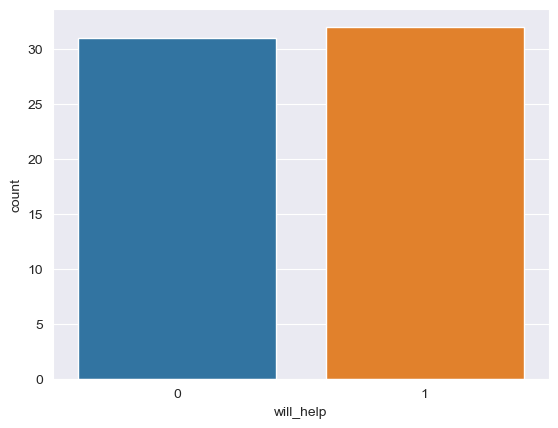

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

TRAINING_DATA_CSV_FILE = "data/training_data.csv"
training_dataset: pd.DataFrame = pd.read_csv(TRAINING_DATA_CSV_FILE)
validation_dataset: pd.DataFrame
training_dataset, validation_dataset = train_test_split(training_dataset, test_size=0.5)

sns.countplot(x="will_help", data=training_dataset)

## Sanity Checks

Let's train on a single sample, to verify data loading is working fine. We expect perfect accuracy after a few iterations.

In [3]:
from transformer_analyser import TransformerTypeAnalyser

type_analyser: TransformerTypeAnalyser = TransformerTypeAnalyser(epochs=5)
# type_analyser.train(training_dataset.head(1))

Instead of a single sample, we now train over a very small dataset. Again, we expect perfect accuracy after a few iterations.

In [4]:
small_sample: pd.DataFrame
_, small_sample = train_test_split(training_dataset, test_size=0.07, stratify=training_dataset["will_help"])

logging.info(small_sample["will_help"].value_counts())
type_analyser = TransformerTypeAnalyser(epochs=10)
# type_analyser.train(small_sample)


INFO:root:1    3
0    2
Name: will_help, dtype: int64


## Training the model
Training and validating with holdout data

In [5]:
type_analyser = TransformerTypeAnalyser(epochs=5, batch_size=8)
type_analyser.train(training_data=training_dataset, testing_data=validation_dataset)


INFO:root:Starting training...
2022-12-23 15:38:00.227248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 15:38:00.227726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 15:38:00.227872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 15:38:00.227945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...bert
......embeddings
.........LayerNorm
............vars
...............0
...............1
.........dropout
............vars
.........vars
............0
............1
............2
......encoder
.........layer
............tf_bert_layer
...............attention
..................dense_output
.....................LayerNorm
........................vars
...........................0
...........................1
.....................dense
........................vars
...........................0
...........................1
.....................dropout
........................vars
.....................vars
..................self_attention
.....................dropout
........................vars
.....................key
........................vars
...........................0
...........................1
.....................query
........................vars
...........................0
...........................1
.....

  0%|          | 0/1 [00:00<?, ?ba/s]

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...bert
......embeddings
.........LayerNorm
............vars
...............0
...............1
.........dropout
............vars
.........vars
............0
............1
............2
......encoder
.........layer
............tf_bert_layer
...............attention
..................dense_output
.....................LayerNorm
........................vars
...........................0
...........................1
.....................dense
........................vars
...........................0
...........................1
.....................dropout
........................vars
.....................vars
..................self_attention
.....................dropout
........................vars
.....................key
........................vars
...........................0
...........................1
.....................query
........................vars
...........................0
...........................1
.....

  0%|          | 0/1 [00:00<?, ?ba/s]

INFO:root:Encoding finished. Starting training


Epoch 1/25


2022-12-23 15:38:16.477484: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55b8c3c6c3d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-23 15:38:16.477502: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A5000 Laptop GPU, Compute Capability 8.6
2022-12-23 15:38:16.480677: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-23 15:38:16.527967: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-23 15:38:16.528925: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234]

2/8 [======>.......................] - ETA: 2s - loss: 0.7936 - sparse_categorical_accuracy: 0.3750  

2022-12-23 15:38:26.261443: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


3/8 [==========>...................] - ETA: 1s - loss: 0.7783 - sparse_categorical_accuracy: 0.3750

2022-12-23 15:38:26.594633: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


4/8 [==============>...............] - ETA: 1s - loss: 0.7576 - sparse_categorical_accuracy: 0.4062

2022-12-23 15:38:26.926838: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5/8 [=================>............] - ETA: 1s - loss: 0.7182 - sparse_categorical_accuracy: 0.5250

2022-12-23 15:38:27.261191: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


6/8 [=====================>........] - ETA: 0s - loss: 0.7126 - sparse_categorical_accuracy: 0.5208

2022-12-23 15:38:27.596672: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - ETA: 0s - loss: 0.7233 - sparse_categorical_accuracy: 0.4762

2022-12-23 15:38:28.238765: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 28s 795ms/step - loss: 0.7233 - sparse_categorical_accuracy: 0.4762 - val_loss: 0.6514 - val_sparse_categorical_accuracy: 0.6984
Epoch 2/25
1/8 [==>...........................] - ETA: 2s - loss: 0.5858 - sparse_categorical_accuracy: 0.7500

2022-12-23 15:38:31.831562: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


4/8 [==============>...............] - ETA: 1s - loss: 0.5765 - sparse_categorical_accuracy: 0.8125

2022-12-23 15:38:32.833380: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


6/8 [=====================>........] - ETA: 0s - loss: 0.5439 - sparse_categorical_accuracy: 0.8542

2022-12-23 15:38:33.497578: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


7/8 [=========================>....] - ETA: 0s - loss: 0.5331 - sparse_categorical_accuracy: 0.8750

2022-12-23 15:38:33.830281: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 475ms/step - loss: 0.5336 - sparse_categorical_accuracy: 0.8730 - val_loss: 0.5194 - val_sparse_categorical_accuracy: 0.8413
Epoch 3/25
1/8 [==>...........................] - ETA: 2s - loss: 0.3657 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:38:35.486824: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


3/8 [==========>...................] - ETA: 1s - loss: 0.3501 - sparse_categorical_accuracy: 0.9583

2022-12-23 15:38:36.165569: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


4/8 [==============>...............] - ETA: 1s - loss: 0.3471 - sparse_categorical_accuracy: 0.9688

2022-12-23 15:38:36.519444: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5/8 [=================>............] - ETA: 1s - loss: 0.3391 - sparse_categorical_accuracy: 0.9750

2022-12-23 15:38:36.841581: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


7/8 [=========================>....] - ETA: 0s - loss: 0.3421 - sparse_categorical_accuracy: 0.9464

2022-12-23 15:38:37.516012: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 471ms/step - loss: 0.3400 - sparse_categorical_accuracy: 0.9365 - val_loss: 0.5271 - val_sparse_categorical_accuracy: 0.7302
Epoch 4/25
1/8 [==>...........................] - ETA: 2s - loss: 0.2311 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:38:39.114859: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


3/8 [==========>...................] - ETA: 1s - loss: 0.1859 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:38:39.786841: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5/8 [=================>............] - ETA: 1s - loss: 0.1801 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:38:40.454888: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 475ms/step - loss: 0.1780 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3710 - val_sparse_categorical_accuracy: 0.8413
Epoch 5/25
1/8 [==>...........................] - ETA: 2s - loss: 0.1253 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:38:42.777287: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


6/8 [=====================>........] - ETA: 0s - loss: 0.0948 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:38:44.445088: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


7/8 [=========================>....] - ETA: 0s - loss: 0.0920 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:38:44.785082: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 459ms/step - loss: 0.0897 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3939 - val_sparse_categorical_accuracy: 0.8413
Epoch 6/25
2/8 [======>.......................] - ETA: 2s - loss: 0.0692 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:38:46.657533: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


3/8 [==========>...................] - ETA: 1s - loss: 0.0645 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:38:46.990830: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


4/8 [==============>...............] - ETA: 1s - loss: 0.0625 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:38:47.323947: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5/8 [=================>............] - ETA: 1s - loss: 0.0603 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:38:47.660070: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


7/8 [=========================>....] - ETA: 0s - loss: 0.0567 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:38:48.326848: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 459ms/step - loss: 0.0566 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4605 - val_sparse_categorical_accuracy: 0.7937
Epoch 7/25
5/8 [=================>............] - ETA: 1s - loss: 0.0474 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:38:51.212538: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 460ms/step - loss: 0.0423 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3838 - val_sparse_categorical_accuracy: 0.8730
Epoch 8/25
8/8 [==============================] - ETA: 0s - loss: 0.0264 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:38:55.742916: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 460ms/step - loss: 0.0264 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3770 - val_sparse_categorical_accuracy: 0.8571
Epoch 9/25
8/8 [==============================] - 4s 460ms/step - loss: 0.0191 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4027 - val_sparse_categorical_accuracy: 0.8413
Epoch 10/25
4/8 [==============>...............] - ETA: 1s - loss: 0.0167 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:39:01.541070: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5/8 [=================>............] - ETA: 1s - loss: 0.0165 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:39:01.877146: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - ETA: 0s - loss: 0.0157 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:39:02.864761: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 462ms/step - loss: 0.0157 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4276 - val_sparse_categorical_accuracy: 0.8571
Epoch 11/25
1/8 [==>...........................] - ETA: 2s - loss: 0.0149 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:39:04.108370: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5/8 [=================>............] - ETA: 1s - loss: 0.0127 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:39:05.448381: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


6/8 [=====================>........] - ETA: 0s - loss: 0.0122 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:39:05.786133: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 463ms/step - loss: 0.0118 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4471 - val_sparse_categorical_accuracy: 0.8571
Epoch 12/25
4/8 [==============>...............] - ETA: 1s - loss: 0.0101 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:39:08.694519: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


7/8 [=========================>....] - ETA: 0s - loss: 0.0097 - sparse_categorical_accuracy: 1.0000

2022-12-23 15:39:09.700255: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 476ms/step - loss: 0.0097 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4622 - val_sparse_categorical_accuracy: 0.8571
Epoch 12: early stopping


INFO:root:Model and Tokenizer saved at ./model
